# Trying and building everything on 1 patient

1 epoch -> 30 sec \
1 sec -> Frequency Rate (Hz)

| Channel Number | Type of Signal       | Label | Frequency Rate (Hz) | Butterworth Notch Filter | Description                                                                             |
|----------------|----------------------|-------|----------------------|--------------------------|-----------------------------------------------------------------------------------------|
| 1              | EOG                 | LOC-A2| 200                  | 0.3 Hz–35 Hz, 50 Hz     | Left eye movements                                                                      |
| 2              | EOG                 | ROC-A1| 200                  | 0.3 Hz–35 Hz, 50 Hz     | Right eye movements                                                                     |
| 3              | EEG                 | F3-A2 | 200                  | 0.3 Hz–35 Hz, 50 Hz     | Brain channels with references A1 and A2, placed in the left and right ear lobes        |
| 4              | EEG                 | C3-A2 | 200                  | 0.3 Hz–35 Hz, 50 Hz     | Brain channels with references A1 and A2, placed in the left and right ear lobes        |
| 5              | EEG                 | O1-A2 | 200                  | 0.3 Hz–35 Hz, 50 Hz     | Brain channels with references A1 and A2, placed in the left and right ear lobes        |
| 6              | EEG                 | F4-A1 | 200                  | 0.3 Hz–35 Hz, 50 Hz     | Brain channels with references A1 and A2, placed in the left and right ear lobes        |
| 7              | EEG                 | C4-A1 | 200                  | 0.3 Hz–35 Hz, 50 Hz     | Brain channels with references A1 and A2, placed in the left and right ear lobes        |
| 8              | EEG                 | O2-A1 | 200                  | 0.3 Hz–35 Hz, 50 Hz     | Brain channels with references A1 and A2, placed in the left and right ear lobes        |
| 9              | Chin EMG            | X1    | 200                  | 10 Hz–70 Hz, 50 Hz      | Chin EMG, placed between the chin and the lower lip                                     |
| 10             | ECG (EKG)           | X2    | 200                  | 50 Hz                   | Electrocardiographic                                                                    |
| 11             | Leg-1 EMG           | X3    | 200                  | 10 Hz–70 Hz, 50 Hz      | Left leg movement                                                                       |
| 12             | Leg-2 EMG           | X4    | 200                  | 10 Hz–70 Hz, 50 Hz      | Right leg movement                                                                      |
| 13             | Snore               | X5    | 200                  | 10 Hz–70 Hz, 50 Hz      | Snore (derived)                                                                         |
| 14             | Flow-1              | X6    | 12.5                 |                          | Airflow (pressure based)                                                                |
| 15             | Flow-2              | DC3   | 25                   |         |   Airflow (pressure based)                                                                                |
| 16             | Abdominal Effort    | X7    | 25                   |                          | Abdominal efforts                                                                       |
| 17 |Abdominal Effort                | X8    |  25                  |         | Abdominal efforts                                                                                         |
| 18             | Pulse Oximetry      | SaO2  | 12.5                 |                          | Pulse oximetry (SaO2)                                                                   |
| 19             | Body Position       | DC8   | 25                   |                          | Body position (BPOS)                                                                    |


In [ ]:
!pip install pyedflib

In [ ]:
import pyedflib
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import re

# Extract

In [ ]:
edf_file = '/kaggle/input/isruc-sg1/ISURC_1/8/8/8.rec'
edf = pyedflib.EdfReader(edf_file)
signals = {}
for i in range(edf.signals_in_file):
    label = edf.getLabel(i)
    signal = edf.readSignal(i)
    signals[label] = signal
edf._close()

In [ ]:
txt_file = '/kaggle/input/isruc-sg1/ISURC_1/8/8/8_1.txt'
annotations_1_1 = pd.read_csv(txt_file, delimiter='\t', header=None)
print("Annotations: ", annotations_1_1.head())

txt_file = '/kaggle/input/isruc-sg1/ISURC_1/8/8/8_2.txt'
annotations_1_2 = pd.read_csv(txt_file, delimiter='\t', header=None)
print("Annotations: ", annotations_1_2.head())

print()

print(f"The shape of the files: \nFile 1_1.txt: {annotations_1_1.shape}\nFile 1_2.txt: {annotations_1_2.shape}")

print()

print(f"Are both of these the same: {(annotations_1_1 == annotations_1_2).all()}")

In [ ]:
xlsx_file = '/kaggle/input/isruc-sg1/ISURC_1/8/8/8_1.xlsx'
excel_data_1_1 = pd.read_excel(xlsx_file)
excel_data_1_1.tail(6)

In [ ]:
xlsx_file = '/kaggle/input/isruc-sg1/ISURC_1/8/8/8_2.xlsx'
excel_data_1_2 = pd.read_excel(xlsx_file)
excel_data_1_2.tail(6)

In [ ]:
signals # the dataset has no consistency !

Let's store these signals and worry about figuring out which signal is which later :) we thus, below find that we can use the epoch*30sec rule to calculate an estimate of the frequency 

In [ ]:
signals['SaO2']

In [ ]:
len(signals['SaO2']), 12.5*904*30

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Design a Butterworth bandpass filter.

    Parameters:
        lowcut (float): Lower cutoff frequency in Hz.
        highcut (float): Higher cutoff frequency in Hz.
        fs (float): Sampling frequency in Hz.
        order (int): Order of the filter (default is 4).

    Returns:
        b, a: Numerator (b) and denominator (a) polynomials of the IIR filter.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass filter to the input signal.

    Parameters:
        data (array): Input signal.
        lowcut (float): Lower cutoff frequency in Hz.
        highcut (float): Higher cutoff frequency in Hz.
        fs (float): Sampling frequency in Hz.
        order (int): Order of the filter (default is 4).

    Returns:
        y (array): Filtered signal.
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(bandpass_filter(signals['X7'][:2_000:2], 0.2, 0.5, 12.5))
plt.plot(bandpass_filter(signals['X8'][:2_000:2], 0.2, 0.5, 12.5))

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(signals['X7'][int((68-1)*(30*25)):int((68-1)*(30*25))+2_000:2])
plt.plot(bandpass_filter(signals['X8'][int((68-1)*(30*25)):int((68-1)*(30*25))+2_000:2], 0.2, 0.5, 12.5))

## INFO
-------------

1) Events specified in the xlsx files, the x_2 file has the Events vs Epoch.
2) The x_1 xlsx file has a few information about the demographics.
3) The singals are all .EDF files and the annotations are provided in the table.
4) There are two txt and xlsx files, as both are scored by two experts.
5) Events and their meaning.
   - L Out: Lights Out
   - L ON: Lights On
   - MChg: Montage Change
   - PLM: Periodic Leg Movement
   - Awake: Awakening
   - CH: Central Hypopnea
   - CA: Central Apnea
   - LM: Leg Movement
   - MP: Movement Periodic
   - OH: Obstructive Hypopnea
   - OA: Obstructive Apnea
   - REM, Aw: Awakening in REM
   - AR: Arousal
   > abrupt change from sleep to wakefulness, or from a "deeper" stage of non-REM sleep to a "lighter" stage.
   
   - MH: Mixed Hypopnea
   > shallow breathing in which the air flow in and out of the airway is less than half of normal-usually associated with oxygen deaturation.

# Transform and Load

## File Structure
----

On the basis of the current model architecture (i.e. the Event Classification using clipped signals) we will save files in folders eeach folder for one event.


Dataset  
├── **Events**  
│   ├── **OH**  
│   │   ├── `S1_p1_1_Event1.npy`  
│   │   ├── `S1_p1_2_Event1.npy`  
│   │   ├── ...  
│   │   └── Format: `{S<Subgroup_number>_p<Patient_ID>_<Expert_number>_Event<Event_Number>.npy}`  
│   ├── **CA**  
│   │   ├── `S1_p1_1_Event4.npy`  
│   │   ├── `S1_p1_2_Event5.npy`  
│   │   ├── ...  
│   │   └── Format: `{S<Subgroup_number>_p<Patient_ID>_<Expert_number>_Event<Event_Number>.npy}`  
│   ├── ...  
│  
├── **Demographic**  
│   ├── `Demographic` (Contains information like age, weight, etc., for all patients)  


**Intuition** -> The patient number and the subgroup number uniquely identify a patient and thus if we later want to add the demographi information to the model we can do so by using the file name. Also adding the subgroup number and the patient number allows us to use "LOOCV" which is essential to ensure no data leakage between CV and Train sets. Adding the Event number and the Expert number is essential to ensure uniqueness of the filename.

## Creating the clipping algorithm

For this development let's use Expert 1

In [ ]:
excel_data = excel_data_1_1.loc[:, ["Epoch", "Stage", "SpO2", "HR", "Events"]]

In [ ]:
excel_data[~(excel_data['Epoch'].isnull())]

In [ ]:
# Getting the "Eventful Epochs" and accounting for extra stupid layers
excel_data[~(excel_data["Events"].isnull() | excel_data['Epoch'].isnull())] # dropping extra data added to the sheet

In [ ]:
# 1 epoch has "30*signal frequency" number of samples

epoch = 1
last_epoch = 904 # as seen in the cell above
signal = "X6" # Let's suppose

signal_frequency = len(signals[signal])/(30*last_epoch)
print(signal_frequency)
start_idx = int((epoch - 1)*(len(signals[signal])/(last_epoch)))
end_idx = int(start_idx + (len(signals[signal])/(last_epoch)))

In [ ]:
down_sampling = int(signal_frequency/12.5)
print(start_idx, end_idx)
clipped_signal = signals[signal][start_idx:end_idx:down_sampling]
# print(clipped_signal)

## Final code for Transform

In [ ]:
# for ISURC SG 1 and 3 -> (subgroup, patient_id, expert_num, session = 1)
# for ISURC SG 2 -> (subgroup, patient_id, expert_num, session_num)

EPOCH_DURATION = 30
BASE_PATH = '/kaggle/input/isruc-sg1'
OUTPUT_PATH = 'Events'

# --------------------------------------- the below line was assuming that the dataset makers cared about the dataset,.. they didn't ---------------------------
# SIGNAL_FREQUENCY = {
#     "LOC-A2": 200,    # Left eye movements
#     "ROC-A1": 200,    # Right eye movements
#     "F3-A2": 200,     # Brain channels with references A1 and A2, placed in the left and right ear lobes
#     "C3-A2": 200,     # Brain channels with references A1 and A2, placed in the left and right ear lobes
#     "O1-A2": 200,     # Brain channels with references A1 and A2, placed in the left and right ear lobes
#     "F4-A1": 200,     # Brain channels with references A1 and A2, placed in the left and right ear lobes
#     "C4-A1": 200,     # Brain channels with references A1 and A2, placed in the left and right ear lobes
#     "O2-A1": 200,     # Brain channels with references A1 and A2, placed in the left and right ear lobes
#     "X1": 200,        # Chin EMG, placed between the chin and the lower lip
#     "X2": 200,        # Electrocardiographic (ECG)
#     "X3": 200,        # Left leg movement (Leg-1 EMG)
#     "X4": 200,        # Right leg movement (Leg-2 EMG)
#     "X5": 200,        # Snore (derived)
#     "X6": 12.5,       # Airflow (pressure-based, Flow-1)
#     "DC3": 25,        # Airflow (pressure-based, Flow-2)
#     "X7": 25,         # Abdominal efforts (1)
#     "X8": 25,         # Abdominal efforts (2)
#     "SaO2": 12.5,     # Pulse oximetry (SaO2)
#     "DC4": 12.5,      # Anonymous signal found in only a few patients not all :(
#     "DC8": 25         # Body position
# }

In [ ]:
def extract_signal(signals, signal_label, epoch, last_epoch):
    # Estimating frequency, assuming epoch length is 30 as given in the paper
    frequency = len(signals[signal_label]) / (last_epoch*EPOCH_DURATION)
    
    start_idx = int((epoch - 1) * (EPOCH_DURATION * frequency))
    end_idx = int(start_idx + (EPOCH_DURATION * frequency))
    
    # Down-sample to 12.5 Hz if necessary
    down_sampling = int(frequency / 12.5)
    clipped_signal = signals[signal_label][start_idx:end_idx:down_sampling]
    
    return clipped_signal

In [ ]:
def load_signal(base_path, subgroup, patient_id, session_num):
    subgroup = f"ISURC_{subgroup}"
    patient_id = f"{patient_id}"
    session_num = f"{session_num}"

    _path = f"{base_path}/{subgroup}/{patient_id}/{patient_id}" # Subgroup 1 and 3
    if subgroup == f"ISURC_{2}":
        _path += f"/{session_num}" # Subgroup 2
        edf_file = f"{_path}/{session_num}.rec"
    else:
        edf_file = f"{_path}/{patient_id}.rec"
    
    edf = pyedflib.EdfReader(edf_file)
    signals = {}
    for i in range(edf.signals_in_file):
        label = edf.getLabel(i)
        signal = edf.readSignal(i)
        signals[label] = signal
    edf._close()

    return signals

In [ ]:
signal = load_signal(BASE_PATH, subgroup=1, patient_id=8, session_num=1)
print(len(signal['X5'])*12.5/200 == len(signal['SaO2'])) # assuming they were sane beings

signal_X5 = extract_signal(signal, 'X5', 904, 904)
len(signal_X5) # as this is 375 these are the last values of the signal, and it's existence confirms that the code is correct

It is observed that there are different frequencies than the mentioned frequencies in the frequency table for signals. i.e. the frequency from the same sensor differ between patients.

So to find a common ground. We assume the frequency of SaO2 to be 12.5 and diregard other metioned frequencies and we calculate the frequency assuming all signals were measured for the same time period. hence must have same samples after dividing by the frequency

In [ ]:
allowed_events = [
    'L Out', 'LOUT', 'L OUT', 'LOut', 'LOn', 'LON', 'L ON', 'L On', 'MChg', 'MChng', 'PLM', 'LM', 'Awake',
    'CH', 'CA', 'MP', 'OH', 'OA', 'AR', 'MH', 'REM', 'Aw', 'REM, Aw'
]

# Function to normalize labels
def normalize_events(event_list):
    # Helper function to normalize a single event
    def normalize_event(event):
        # Normalize "L Out" variations
        event = re.sub(r'\b(L\s*Out|L\s*OUT|LOUT|Lout|LOut)\b', 'L Out', event)
        # Normalize "L In" variations
        event = re.sub(r'\b(L\s*In|L\s*IN|LIN|Lin|LIn)\b', 'L In', event)
        # Normalize "MChg" variations
        event = re.sub(r'\b(MChg|MChng)\b', 'MChg', event)
        return event

    # Apply normalization to each event
    normalized_events = [normalize_event(e) for e in event_list]
    
    # Special handling for "REM, Aw" unification
    if any(e in ['REM', 'Aw', 'REM, Aw'] for e in normalized_events):
        # Remove individual "REM" and "Aw", add unified "REM" representing REM, Aw such that it dosen't conflict with the code further
        normalized_events = [e for e in normalized_events if e not in ['REM', 'Aw', 'REM, Aw']]
        normalized_events.append('REM')
    
    # Deduplicate and return
    return list(set(normalized_events))


def clean_row(row):
    # Initialize clean values
    hr = None
    events = []

    # Process SpO2 column
    hr_value = re.findall(r'\b\d+\b', str(row['HR'])) # Extract integers
    event_in_hr = re.findall('r\b(?:' + '|'.join(allowed_events) + r')\b', str(row['HR']))
    if hr_value:
        hr = int(hr_value[0])

    # Process Events Column
    event_in_events = re.findall(r'\b(?:' + '|'.join(allowed_events) + r')\b', str(row['Events']))  # Extract allowed events
    hr_in_events = re.findall(r'\b\d+\b', str(row['Events']))  # Extract numbers in Events

    events.extend(event_in_hr + event_in_events)

    if not hr and hr_in_events:
        hr = int(hr_in_events[0])

    events = normalize_events(events)
    events = sorted(list(set(events))) # Check for Redundancy

    return pd.Series({'HR': hr, 'Events': ','.join(events)})

In [ ]:
def clean_excel(df, subgroup, patient_id):
    # File -> S_1 p_29 has Title 'hich' instead of epoch
    if 'hich' in df.columns:
        df.rename(columns={'hich': 'Epoch'}, inplace=True)

    # File -> S_2 P_2 P_3 P_4 has swapped HR and SpO2
    if (subgroup == 2 and (patient_id == 2 or patient_id == 3 or patient_id == 4)) and df.columns[2] == 'HR':
        df.rename(columns={'HR': 'SpO2', 'SpO2': 'HR'}, inplace=True)
        
    # Some Files have Title "Epochs" rather than "Epoch"
    if "Epochs" in df.columns:
        df.rename(columns={'Epochs': 'Epoch'}, inplace=True)
    if "Stages" in df.columns:
        df.rename(columns={'Stages': 'Stage'}, inplace=True)

    clean_df = df[['HR', 'Events', 'BPOS']].apply(clean_row, axis=1)
    df.update(clean_df)
    
    return df

In [ ]:
def load_excel(base_path, subgroup, patient_id, expert_num, session_num, eventful = True):
    subgroup = f"ISURC_{subgroup}"
    patient_id = f"{patient_id}"
    session_num = f"{session_num}"

    _path = f"{base_path}/{subgroup}/{patient_id}/{patient_id}" # Subgroup 1 and 3
    if subgroup == f"ISURC_{2}":
        _path += f"/{session_num}" # Subgroup 2
        xlsx_file = f"{_path}/{session_num}_{expert_num}.xlsx"
    else:
        xlsx_file = f"{_path}/{patient_id}_{expert_num}.xlsx"
    
    df = pd.read_excel(xlsx_file)

    # Fixing some Label Errors
    df = clean_excel(df, subgroup, patient_id)
    df = df[~(df['Epoch'].isnull())] # Remove extra rows with no information
    
    df = df.loc[:, ["Epoch", "Stage", "SpO2", "HR", "Events"]] # Keeping only relevant colunmns
    
    if (eventful == True):
        # Getting the Eventful epochs
        df = df[~(df["Events"] == '')]

    return df

In [ ]:
load_excel(BASE_PATH, 1, 8, 1, 1, False)

In [ ]:
for el1, el2 in zip(list(load_excel(BASE_PATH, 1, 6, 1, 1)['Events']), list(load_excel(BASE_PATH, 1, 6, 2, 1)['Events'])):
    print(f"{el1} | {el2}")

In [ ]:
def process_events(base_path, subgroup, patient_id, expert_num, session_num, save=False):
    signals = load_signal(base_path, subgroup, patient_id, session_num)
    events_df = load_excel(base_path, subgroup, patient_id, expert_num, session_num)

    # Calculating the last epoch, ideally should be able to just look at the light on event and use that but now i am scared if we will find a light on :(
    last_epoch = int(load_excel(base_path, subgroup, patient_id, expert_num, session_num, eventful=False).iloc[-1]['Epoch'])

    event_counter = {}
    for index, row in events_df.iterrows():
        epoch = int(row['Epoch'])
        event_types = row['Events'].split(",")  # Getting all the events for multiple events
        sleep_stage = row['Stage'].lower()

        for event in event_types:
            event = event.strip().lower()  # Removing potential whitespaces
            # starts from 0 for every subgroup, patient_id, expert_num, session_num pair -> and then is unique for every event
            # => Event = 145 means, the 145th 'non_event' for that particular patient in that session by that expert.
            event_counter[event] = event_counter.get(event, 0) + 1

            # Create a DataFrame to hold all signals for this event
            event_signals_df = pd.DataFrame()

            # Extract and store signals
            max_length = 0  # Track the longest signal length for consistent NaN filling
            for signal_name in signals.keys():
                clipped_signal = extract_signal(signals, signal_name, epoch, last_epoch)

                # Add the signal as a column to the DataFrame
                event_signals_df[signal_name] = pd.Series(clipped_signal)
                max_length = max(max_length, len(clipped_signal))

            # Ensure all columns have the same length by padding with NaN
            event_signals_df = event_signals_df.reindex(range(max_length))

            # Save the DataFrame
            event_folder = os.path.join(OUTPUT_PATH, event)
            os.makedirs(event_folder, exist_ok=True)

            file_name = (
                f"S{subgroup}_p{patient_id}_{expert_num}_Stage{sleep_stage}_"
                f"Event{event_counter[event]}_Session{session_num}.csv"
            )
            if save:
                event_signals_df.to_csv(os.path.join(event_folder, file_name), index=False)
            else:
                print(epoch, file_name)

In [ ]:
# process_events(BASE_PATH, 1, 8, 1, 1)

In [ ]:
def get_patients_list(subgroup):
    if subgroup == 1:
        patients_list = range(1, 31)
        # patients_list = range(31, 61)
        # patients_list = range(61, 91)
        # patients_list = range(91, 101)
    elif subgroup == 2:
        patients_list = range(1, 9)
    elif subgroup == 3:
        patients_list = range(1, 11)

    return patients_list

def get_sessions(subgroup):
    
    if subgroup == 1 or subgroup == 3:
        sessions = [1]
    elif subgroup == 2:
        sessions = [1, 2]

    return sessions

check = (100*2) + (8*2*2) + (10*2)
count = 0

# for subgroup in [1]: # batch 1, 2, 3, 4
# for subgroup in [2]: # batch 5
for subgroup in [3]: # batch 6

    patients_list = get_patients_list(subgroup)
    
    for patient_id in patients_list:
        for expert_num in [1, 2]:
            
            sessions = get_sessions(subgroup)
    
            if subgroup == 1 or subgroup == 3:
                sessions = [1]
            elif subgroup == 2:
                sessions = [1, 2]

            for session_num in sessions:
                print(f"Processing: Patient: {patient_id}, from Subgroup: {subgroup}")
                print(f"Results by Expert: {expert_num}")
                print(f"From session: {session_num}")
                process_events(BASE_PATH, subgroup, patient_id, expert_num, session_num, save=True)
                count += 1
                print()

if count == check:
    print(f"All files transformed")
else:
    print(count, check)

In [ ]:
!zip -r /kaggle/working/Events.zip /kaggle/working/Events > /dev/null

In [ ]:
!rm -rf /kaggle/working/*

In [ ]:
# signals = load_signal(BASE_PATH, 1, 11, 1)
# signals.keys()

Note 
----

there are problem with the signal nameing, like sometimees the keys are named SpO2 sometimes SaO2 sometimes there are 19 signals sometimes 20 sometimes the probe names are different, handle all this while loading dataset for modelling

# Inter Annotator Reliability

In [ ]:
def load_annotations(base_path, subgroup, patient_id, session_num):
    df_1 = load_excel(base_path, subgroup, patient_id, 1, session_num, False)
    df_2 = load_excel(base_path, subgroup, patient_id, 2, session_num, False)

    df = df_1.drop(columns=["Events"], axis = 1)
    df['Expert1'] = df_1['Events']
    df['Expert2'] = df_2['Events']
    
    return df

In [ ]:
def compute_kappa(merged_df):
    # Drop rows with missing values (epochs not annotated by both)
    clean_df = merged_df.dropna()
    annotator1 = clean_df['Expert1']
    annotator2 = clean_df['Expert2']
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(annotator1, annotator2)
    return kappa

In [ ]:
def compute_percentage_agreement(merged_df):
    clean_df = merged_df.dropna()
    agreement = (clean_df['Expert1'] == clean_df['Expert2']).mean()
    return agreement * 100

In [ ]:
annotations = load_annotations(BASE_PATH, 1, 1, 1)
annotations.head()

In [ ]:
compute_kappa(annotations)

In [ ]:
compute_percentage_agreement(annotations)

In [ ]:
def get_patients_list(subgroup):
    if subgroup == 1:
        patients_list = range(1, 101)
    elif subgroup == 2:
        patients_list = range(1, 9)
    elif subgroup == 3:
        patients_list = range(1, 11)

    return patients_list

def get_sessions(subgroup):
    
    if subgroup == 1 or subgroup == 3:
        sessions = [1]
    elif subgroup == 2:
        sessions = [1, 2]

    return sessions

check = (100*2) + (8*2*2) + (10*2)
count = 0

inter_annotator_reliability = []
percentage_similarity = []

for subgroup in [1, 2, 3]:

    patients_list = get_patients_list(subgroup)
    
    for patient_id in patients_list:    
        sessions = get_sessions(subgroup)

        if subgroup == 1 or subgroup == 3:
            sessions = [1]
        elif subgroup == 2:
            sessions = [1, 2]

        for session_num in sessions:
            count += 1
            
            # print(f"Processing: Patient: {patient_id}, from Subgroup: {subgroup}")
            # print(f"From session: {session_num}")

            annotations = load_annotations(BASE_PATH, subgroup, patient_id, session_num)
            # try:
            #     annotations = load_annotations(BASE_PATH, subgroup, patient_id, session_num)
            # except:
            #     print(f"Error in processing: Patient: {patient_id}, from Subgroup: {subgroup} From session: {session_num}")
            #     pass

            kappa_score = compute_kappa(annotations)
            similarity = compute_percentage_agreement(annotations)
            
            inter_annotator_reliability.append(kappa_score)
            percentage_similarity.append(similarity)

            if kappa_score < 0.5 or similarity < 80:
                print(f"Kappa Score: {kappa_score} Percentage Similarity: {similarity}")
                print(f"Processing: Patient: {patient_id}, from Subgroup: {subgroup}")
                print(f"From session: {session_num}")


            # print(f"Cohen's Kappa Score: {compute_kappa(annotations):.2f}")
            # print(f"Percentage Agreement: {compute_percentage_agreement(annotations):.2f}")
            # print()

if count == check:
    print(f"All files transformed")

There are errors in SpO2, Events and BPOS columns, now since we are not using the BPOS columns, and instance of a element of BPOS column in the Event columns can be removed.

For the SpO2 and Events columns, lets employ a RegEx to solve this. since the number are seperated by a ' ' we can also split and check if the last letter of the SpO2 column is a letter or the first word of the element after split is a number in case of Events.

In which case, we shall do the changes

Allowed values in SpO2 -> integer \
Allowed values in Events -> L Out, LOut, LOn, L On, MChg, MChng, PLM, LM, Awake, CH, CA, MP, OH, OA, 'REM, Aw', AR, MH

## After conversion
-----

Kappa Score goes from a mean of 0.30 to 0.40; and Percentage Aggrement goes from 60% to 80%

In [ ]:
inter_annotator_reliability = np.array(inter_annotator_reliability)
percentage_similarity = np.array(percentage_similarity)

In [ ]:
percentage_similarity.mean()

In [ ]:
plt.plot(inter_annotator_reliability)

In [ ]:
plt.plot(percentage_similarity)

# Sampling Non-events
----

As checked in `ISURC_EDA` notebook, we have 43,267 event-ful samples, thus we wish to sample non-events in the order of 43,000.

To maintain fairness amongst groups, we sample Using a hybrid approach of proportional sampling, and equal sampling.

Since we have $100+(2 \times 8)+10 = 126$ samples, we select:-

**Subgroup 1:-**
$$\frac{100}{126} \times 43,000 \approx 35,714$$
Hence, we sample 35,000.

**Subgroup 2:-**
$$\frac{16}{126} \times 43,000 \approx 5,714$$
We sample 5,600

**Subgroup 3:-**
$$\frac{10}{126} \times 43,000 \approx 3,571$$
We oversample and sample 4,000 so that we do not under-represent this subgroup.

And also, to represent everything as fair on a patients level we sample roughly 350 epochs of non events from each patient. \
> Subgroup 1:- 350 \
Subgroup 2:- 350 \
Subgroup 3:- 400

In [ ]:
def fetch_non_events_number(subgroup):
    if (subgroup == 1) or (subgroup == 2):
        return 350
    if (subgroup == 3):
        return 400

def process_non_events(base_path, subgroup, patient_id, session_num, save=False):
    signals = load_signal(base_path, subgroup, patient_id, session_num)
    
    events_df_1 = load_excel(base_path, subgroup, patient_id, 1, session_num, eventful=False)
    events_df_2 = load_excel(base_path, subgroup, patient_id, 2, session_num, eventful=False)

    # Calculating the last epoch, ideally should be able to just look at the light on event and use that but now i am scared if we will find a light on :(
    last_epoch = int(load_excel(base_path, subgroup, patient_id, 2, session_num, eventful=False).iloc[-1]['Epoch'])

    non_events_df = events_df_1[(events_df_1['Events'] == '') & (events_df_2['Events'] == '')] # Now we only have non-events
    
    # Getting the right number of non-events
    num_non_events = fetch_non_events_number(subgroup)

    # Checking if enough non-events are present
    if non_events_df.shape[0] >= num_non_events:
        # trim it down to the right number
        non_events_df = non_events_df.loc[:num_non_events]
    # if not then sample all of them :)

    # Removing nan epochs
    non_events_df = non_events_df[~(non_events_df['Epoch'].isnull())]
    
    event_counter = {}
    for index, row in non_events_df.iterrows():
        epoch = int(row['Epoch'])
        event_types = ['Non-Event']
        sleep_stage = row['Stage'].lower()

        for event in event_types:
            event = event.strip().lower()  # Removing potential whitespaces
            event_counter[event] = event_counter.get(event, 0) + 1

            # Create a DataFrame to hold all signals for this event
            event_signals_df = pd.DataFrame()

            # Extract and store signals
            max_length = 0  # Track the longest signal length for consistent NaN filling
            for signal_name in signals.keys():
                clipped_signal = extract_signal(signals, signal_name, epoch, last_epoch)

                # Add the signal as a column to the DataFrame
                event_signals_df[signal_name] = pd.Series(clipped_signal)
                max_length = max(max_length, len(clipped_signal))

            # Ensure all columns have the same length by padding with NaN
            event_signals_df = event_signals_df.reindex(range(max_length))

            # Save the DataFrame
            event_folder = os.path.join(OUTPUT_PATH, event)
            os.makedirs(event_folder, exist_ok=True)

            file_name = (
                f"S{subgroup}_p{patient_id}_Stage{sleep_stage}_"
                f"Event{event_counter[event]}_Session{session_num}.csv"
            )
            
            if save:
                event_signals_df.to_csv(os.path.join(event_folder, file_name), index=False)
            else:
                print(epoch, file_name)

In [ ]:
def get_patients_list(subgroup):
    if subgroup == 1:
        patients_list = range(1, 51) # batch 1
        # patients_list = range(51, 101) # batch 2
    elif subgroup == 2:
        patients_list = range(1, 9)
    elif subgroup == 3:
        patients_list = range(1, 11)

    return patients_list

def get_sessions(subgroup):
    if subgroup == 1 or subgroup == 3:
        sessions = [1]
    elif subgroup == 2:
        sessions = [1, 2]

    return sessions

check = (100*2) + (8*2*2) + (10*2)
count = 0

# for subgroup in [1]: # batch 1, 2
# for subgroup in [2]: # batch 3
for subgroup in [3]: # batch 4
    
    patients_list = get_patients_list(subgroup)
    
    for patient_id in patients_list:
        sessions = get_sessions(subgroup)

        if subgroup == 1 or subgroup == 3:
            sessions = [1]
        elif subgroup == 2:
            sessions = [1, 2]

        for session_num in sessions:
            print(f"Processing: Patient: {patient_id}, from Subgroup: {subgroup}")
            print(f"From session: {session_num}")
            process_non_events(BASE_PATH, subgroup, patient_id, session_num, save=True)
            count += 1
            print()

if count == check:
    print(f"All files transformed")

In [ ]:
!zip -r /kaggle/working/Events.zip /kaggle/working/Events > /dev/null

In [ ]:
!rm -rf /kaggle/working/*

# Verification
----

```python
load_excel(base_path, subgroup, patient_id, expert_num, session_num, eventful = True):
load_signal(base_path, subgroup, patient_id, session_num):
process_non_events(base_path, subgroup, patient_id, session_num, save=True):
```


## Event 1
----

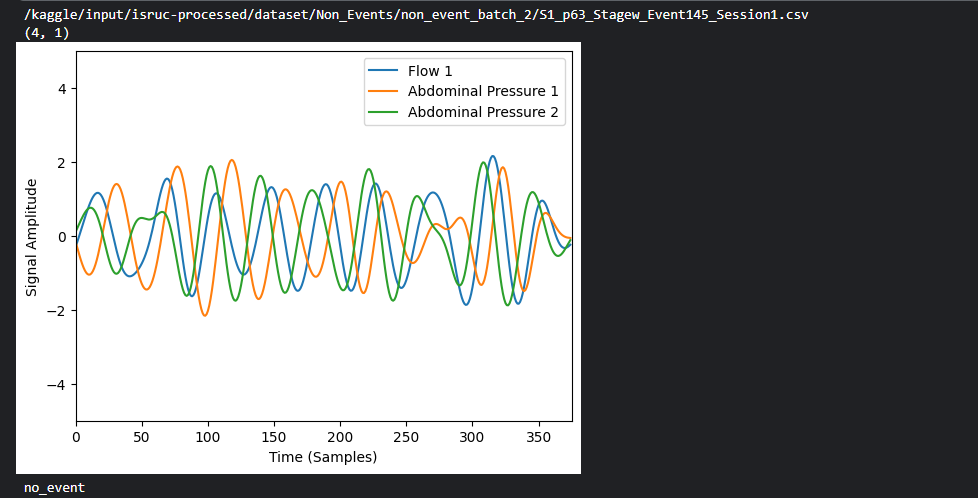

In [ ]:
events_1 = load_excel(BASE_PATH, 1, 63, 1, 1, eventful=False)
events_2 = load_excel(BASE_PATH, 1, 63, 2, 1, eventful=False)

In [ ]:
# 0th event will have the first valid epoch 
events_1[(events_1['Events'] == '') & (events_2['Events'] == '')].iloc[[143, 144, 145, 146, 147], :]

In [ ]:
signals = load_signal(BASE_PATH, 1, 63, 1)

signals.keys()

In [ ]:
print(f"Total Epochs: {events_1[~(events_1['Epoch'].isnull())].iloc[-1]['Epoch']}")

print(f"Estimated frequencies:")
for key, value in signals.items():
    print(f"{key} = {len(value)*12.5 / len(signals['SpO2'])}")    

In [ ]:
# Flow - 1
flow_1 = signals['29']

# Abdominal Pressure - 1
abd_pr_1 = signals['30']

# Abdominal Pressure - 2
abd_pr_2 = signals['31']

In [ ]:
# Clipping signals on Epochs 
Epochs = [150, 156, 157, 158, 159]

for epoch in Epochs:
    clipped_flow_1 = flow_1[(epoch-1)*int(30*12.5):(epoch)*int(30*12.5):int(12.5/12.5)]
    clipped_abd_pr_1 = abd_pr_1[(epoch-1)*int(30*25):(epoch)*int(30*25):int(25/12.5)]
    clipped_abd_pr_2 = abd_pr_2[(epoch-1)*int(30*25):(epoch)*int(30*25):int(25/12.5)]

    clipped_flow_1 = (clipped_flow_1 - clipped_flow_1.mean()) / clipped_flow_1.std()
    clipped_abd_pr_1 = (clipped_abd_pr_1 - clipped_abd_pr_1.mean()) / clipped_abd_pr_1.std()
    clipped_abd_pr_2 = (clipped_abd_pr_2 - clipped_abd_pr_2.mean()) / clipped_abd_pr_2.std()

    plt.axis([0, 375, -5, 5])
    plt.plot(bandpass_filter(clipped_flow_1, 0.2, 0.5, 12.5), label='flow_1')
    plt.plot(bandpass_filter(clipped_abd_pr_1, 0.2, 0.5, 12.5), label='abdominal pressure 1')
    plt.plot(bandpass_filter(clipped_abd_pr_2, 0.2, 0.5, 12.5), label='abdominal preessure 2')
    plt.legend()
    plt.show()

In [ ]:
plt.axis([0, 375, -5, 5])
plt.plot((bandpass_filter(extract_signal(signals, '29', 156, 954), 0.2, 0.5, 12.5) - bandpass_filter(extract_signal(signals, '29', 156, 954), 0.2, 0.5, 12.5).mean())/(bandpass_filter(extract_signal(signals, '29', 156, 954), 0.2, 0.5, 12.5).std()))
plt.plot((bandpass_filter(extract_signal(signals, '30', 156, 954), 0.2, 0.5, 12.5) - bandpass_filter(extract_signal(signals, '30', 156, 954), 0.2, 0.5, 12.5).mean())/(bandpass_filter(extract_signal(signals, '30', 156, 954), 0.2, 0.5, 12.5).std()))
plt.plot((bandpass_filter(extract_signal(signals, '31', 156, 954), 0.2, 0.5, 12.5) - bandpass_filter(extract_signal(signals, '31', 156, 954), 0.2, 0.5, 12.5).mean())/(bandpass_filter(extract_signal(signals, '31', 156, 954), 0.2, 0.5, 12.5).std()))

Clearly the results of the extract signal function match the manually created results, and so do the final signals given the epoch number.

Now the only fault that could lie in the way we calculate the epoch to index. :)

In [ ]:
# process_non_events(BASE_PATH, 1, 63, 1)

## Event 2
----
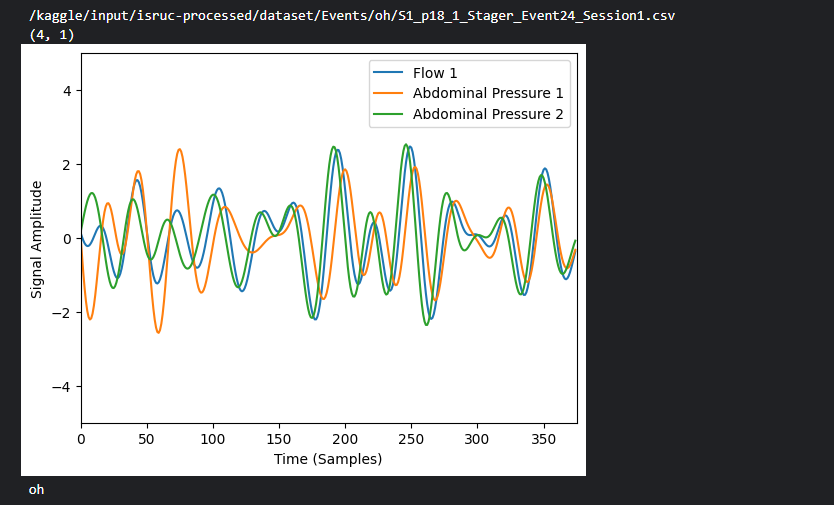

In [ ]:
events_1 = load_excel(BASE_PATH, 1, 18, 1, 1, eventful=True)

In [ ]:
print(events_1[events_1['Stage'] == 'R'].shape)
events_1[events_1['Stage'] == 'R']

In [ ]:
# process_events(BASE_PATH, 1, 18, 1, 1) -> Epoch 496

In [ ]:
signals = load_signal(BASE_PATH, 1, 18, 1)

signals.keys()

In [ ]:
print(f"Total Epochs: {events_1[~(events_1['Epoch'].isnull())].iloc[-1]['Epoch']}")

print(f"Estimated frequencies:")
for key, value in signals.items():
    print(f"{key} = {len(value)*12.5 / len(signals['SaO2'])}")  

In [ ]:
# Flow - 1
flow_1 = signals['X6']

# Abdominal Pressure - 1
abd_pr_1 = signals['X7']

# Abdominal Pressure - 2
abd_pr_2 = signals['X8']

In [ ]:
# Clipping signals on Epochs 
Epochs = [496]

for epoch in Epochs:
    clipped_flow_1 = flow_1[(epoch-1)*int(30*12.5):(epoch)*int(30*12.5):int(12.5/12.5)]
    clipped_abd_pr_1 = abd_pr_1[(epoch-1)*int(30*25):(epoch)*int(30*25):int(25/12.5)]
    clipped_abd_pr_2 = abd_pr_2[(epoch-1)*int(30*25):(epoch)*int(30*25):int(25/12.5)]

    clipped_flow_1 = (clipped_flow_1 - clipped_flow_1.mean()) / clipped_flow_1.std()
    clipped_abd_pr_1 = (clipped_abd_pr_1 - clipped_abd_pr_1.mean()) / clipped_abd_pr_1.std()
    clipped_abd_pr_2 = (clipped_abd_pr_2 - clipped_abd_pr_2.mean()) / clipped_abd_pr_2.std()

    plt.axis([0, 375, -5, 5])
    plt.plot(bandpass_filter(clipped_flow_1, 0.2, 0.5, 12.5), label='flow_1')
    plt.plot(bandpass_filter(clipped_abd_pr_1, 0.2, 0.5, 12.5), label='abdominal pressure 1')
    plt.plot(bandpass_filter(clipped_abd_pr_2, 0.2, 0.5, 12.5), label='abdominal preessure 2')
    plt.legend()
    plt.show()

They are in perfect agreement and since we are not using the Event Number anywhere hence we can conclude that as long the annotaiton to epoch relation is correct we are getting the right signals in the dataset

## Epoch to Signal relation checking
----

If the code perfectly divides the signal into clips that is, \
epoch 0 DNE and epoch 1 Exists with 375 length => epoch 1 is the first epoch \
epoch `last_epoch` exists and has length 375 while epoch `last_epoch+1` DNE => epoch `last_epoch` is the last epoch \
And since the clips are contiguous we can say that the code is correct

In [ ]:
for epoch in [0, 1, 999, 1000]:
    clipped_flow_1 = flow_1[(epoch-1)*int(30*12.5):(epoch)*int(30*12.5):int(12.5/12.5)]
    clipped_abd_pr_1 = abd_pr_1[(epoch-1)*int(30*25):(epoch)*int(30*25):int(25/12.5)]
    clipped_abd_pr_2 = abd_pr_2[(epoch-1)*int(30*25):(epoch)*int(30*25):int(25/12.5)]

    print(f"Epoch: {epoch}")
    print(f"length of signals")
    print(len(clipped_flow_1), len(clipped_abd_pr_1), len(clipped_abd_pr_2))

Hence, Proven to be correct

This implies our ETL code correctly synchronises the Signals and the events